在本教程中，我们将从核磁共振的数据中获取自由感应衰变（FID），并将其绘制为核磁共振谱图。正如你在下面看到的，本教程所导入的库大多都很常见，但nmrglue是一个之前的教程中没有导入的库。nmrglue包是一个用于分析和绘制核磁共振波谱的开源软件包，可能没有预装在您的python版本中。再开始本教程前请您安装nmrglue，详见[nmrglue安装教程](https://nmrglue.readthedocs.io/en/latest/install.html)

此外，你也需要4个用于提取并绘制NMR谱图的数据集，分别是 D2O\_fid, D2O\_procpar, NoD2O\_fid, and NoD2O\_procpar files,。这些数据都是通过安捷伦400 MHz NMR 仪器获得的

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import nmrglue as ng

nmrglue软件包的好处是它允许我使用NMR仪器软件创建的各种文件导入数据。例如，我们可以使用nmrglue包中的read_fid（）函数来读取Agilent NMR文件，而无需先将其转换为开源数据文件。我们将从NoD2O_fid和NoD2O_procpar文件开始，其中包含创建一个NMR谱所需的数据。

In [11]:
dic, data = ng.fileio.agilent.read_fid("NoD2O_fid", as_2d=True)
params = ng.fileio.agilent.read_procpar("NoD2O_procpar")


现在我们已经读取了fid和参数文件，我们就可以开始使用它了。首先，或许你还记得，NMR收集的数据叫做自由感应衰变，又称为fid。那么这些数据长什么样子？

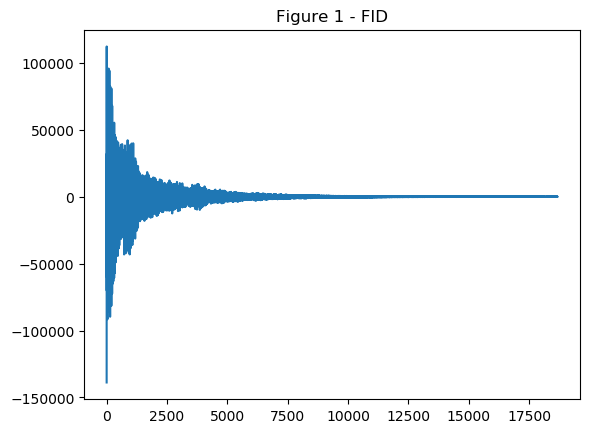

In [12]:
plt.plot(data.real[0])
plt.title("Figure 1 - FID")
plt.show()

运行上面的代码，在下方现实的图像就是FID。显然有几个问题。首先x轴是什么？这是安捷伦（和大多数NMR）软件为了减小FID文件的大小，将存储FID数据的方式变换为一系列值，因此当我们绘制数据时，x轴是点编号。然而，x轴应该是时间，而不是点数，因此我们必须创建一个点数组，其中包含收集每个数据点的时间值。要做到这一点，我们可以使用FID的总采集时间和总点数来计算每个点的时间，然后使用它来创建一个时间数组。采集时间以“at”的形式存储在上面我导入的“params”数组中。如果你感兴趣，可以试着阅读nmrglue的教程。

In [13]:
acq_time = float(params['at']['values'][0])
time_per_point = acq_time/(data.shape[1])
time=np.arange(0,acq_time,time_per_point)
print("The FID acquisition took " + "{:1.5}".format(acq_time) + " seconds.")

The FID acquisition took 2.6001 seconds.


现在我们就可以绘制出将x轴变换为时间的图像了

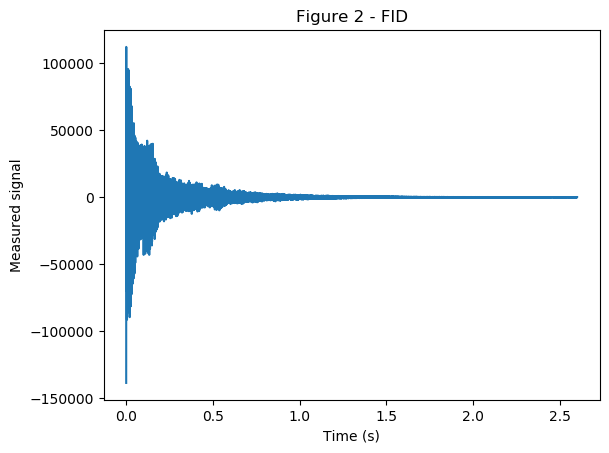

In [14]:
plt.plot(time,data.real[0])
plt.title("Figure 2 - FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

事实上，在FT-NMR中有两个接收器，一个沿着核磁共振的x轴，一个沿核磁共振的y轴，每个接收器收集一个FID。一个存储为“实”，另一个存储“虚”，但这些名称只是数学上的方便。上面的FID是存储为真实值的FID。存储为虚拟的那个看起来像什么？

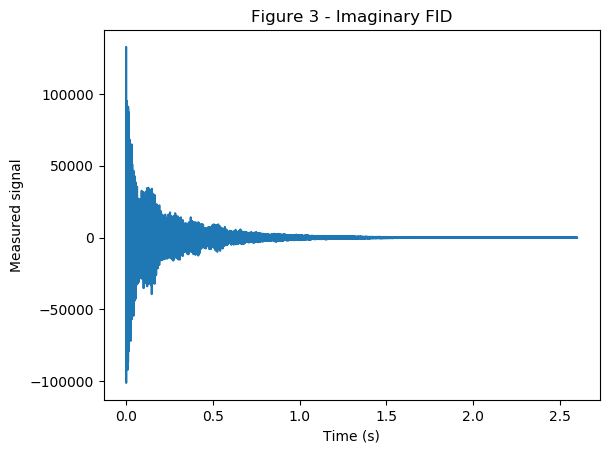

In [15]:
plt.plot(time,data.imag[0])
plt.title("Figure 3 - Imaginary FID")
plt.xlabel('Time (s)')
plt.ylabel('Measured signal')
plt.show()

实际上很难看不出两者之间有什么区别，但值得注意的是，两者的确是不同的。为了将FID转换成我们可以实际进行分析的NMR谱，我们必须对其进行傅里叶变换。幸运的是，numpy包有一个名为fft（）的傅里叶变换函数（用于快速傅里叶变换）。

In [16]:
fftdata = np.fft.fft(data)

看看现在NMR谱长什么样.

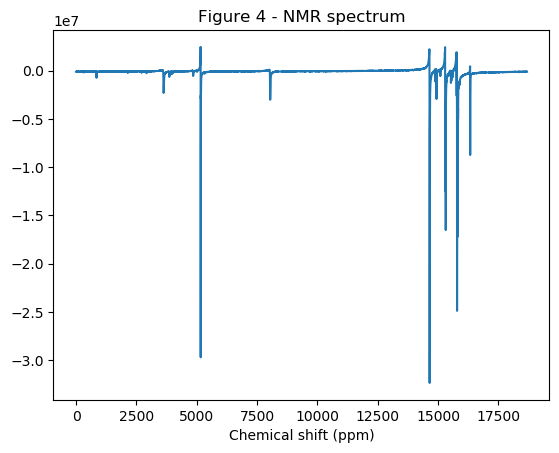

In [17]:
plt.plot(fftdata.real[0])
plt.title("Figure 4 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

看出什么不对的地方了吗？对于质子核磁共振(H NMR)，我们通常预计氢原子核的化学位移在0到10之间，而不是17500。而且峰大多指向下方，并具有奇怪的边缘现象。所以问题在哪里？事实上，我们只是还没有完成。首先，当我们对FID进行傅里叶变换时，我们的x轴从时间（s）变为频率（s$^{-1}$），我们必须执行额外的步骤将其转换为化学位移（ppm）。此外，我们需要记住，我们的数据存储为没有时间的点，因此我们还需要在时间数组上使用fft（）函数来创建正确的x轴。

In [18]:
NMR_freq = 400
freq = np.fft.fftfreq(time.shape[0],time_per_point)
chem_shift = -(freq - 1986)/NMR_freq

经过多次尝试，可以发现三甲基硅烷(TMS)峰值的频率值为1986，因此我们从频率中减去该值，也就是将TMS峰作为基准，得到TMS峰值为零。那么，现在的光谱是什么样子的？

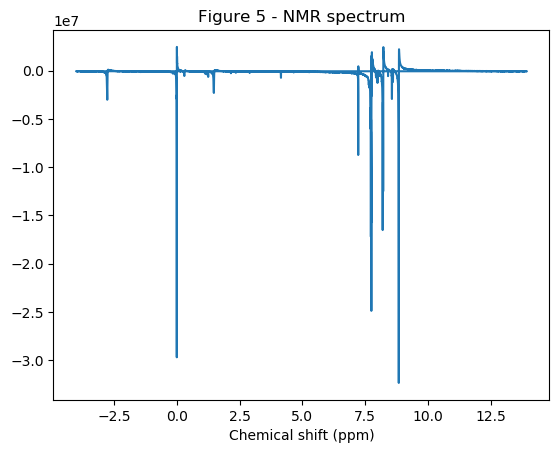

In [19]:
plt.plot(chem_shift,fftdata.real[0])
plt.title("Figure 5 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

现在谱图看起来正常了一些，但我们仍然有两个问题。第一个是次要的，标准的核磁共振波谱惯例是将正的化学位移向左，而不是向右，所以我们需要转换我们的x轴。另一个更为严重的问题是峰值看起来仍然很奇怪。这里就解释了上面为什么会有实和虚FID。现在，我们只绘制傅里叶变换的真实FID，结果是我们的峰值与检测器的相位不同。因此，我们需要将真实数据和虚拟数据相结合，以使所有数据都处于同一相位。如果核磁共振的相位设置出现了什么问题，在这里我们可以对其进行改动。这里，我们需要手动改变相位。数学上，这是实际数据乘以$\cos｛θ｝$+虚拟数据乘以$\sin｛θ$，我们需要找到θ。经过多次尝试，我们发现合适的$\theta$是10。

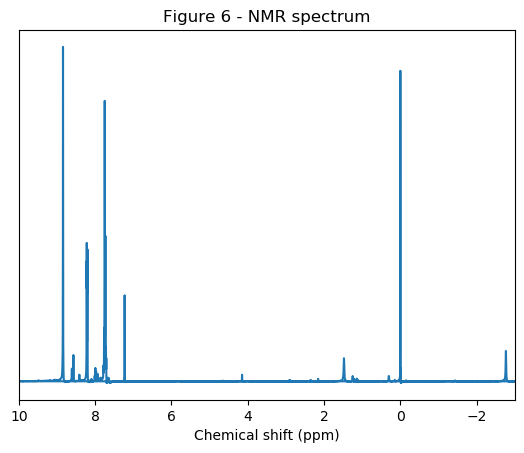

In [20]:
theta = np.degrees(10)
plt.plot(chem_shift,fftdata.real[0]*np.cos(np.radians(theta)) + fftdata.imag[0]*np.sin(np.radians(theta)))
ax = plt.gca()
ax.set_xlim(-3,10)
ax.set_xlim(ax.get_xlim()[::-1])
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
plt.title("Figure 6 - NMR spectrum")
plt.xlabel("Chemical shift (ppm)")
plt.show()

这就是最终的核磁共振波谱。如果需要，可以使用不同的$\theta$值来查看其对图形的影响。现在，你可以试着使用D2O_fid和D2O_procpar文件创建NMR光谱，并将其与上述光谱进行比较。您所绘制的光谱是针对与上述相同的材料，但是一些D${2}$O添加到了核磁管中。

小问题：添加D$_{2}$O前后的光谱之间有什么区别？如果知道更改是由于添加了D$_{2}$O，您对该材料有什么看法？

**回答**